In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import dascore as dc
import pandas as pd
import random
import dascore as dc
import matplotlib.pyplot as plt

In [ ]:
# Path to your .h5 file
# file_path = '/bedrettolab/E1B/DAS/2024_FORGE/DATA_RAW_fromOpenei/April_2024/v1.0.0/16B_StrainRate_20240408T154328+0000_44283.h5'
file_path = '/bedrettolab/E1B/DAS/2024_FORGE/DATA_RAW_fromOpenei/April_2024/v1.0.0/16B_StrainRate_20240408T154340+0000_44284.h5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Access the 'Acoustic' dataset
    dataset = file['Acoustic']
    
    # Read the data into a numpy array (or slice it if the data is too large)
    data = dataset[:]

# Extract date and time
date_str = os.path.basename(file_path).split('_')[2]  # Get '20240408T154328'
date_part, time_part = date_str.split('T')  # Split into date and time

# Convert date and time to human-readable format
date_time_str = f"{date_part} {time_part}".split('+')[0]
formatted_date_time = datetime.strptime(date_time_str, "%Y%m%d %H%M%S").strftime("%B %d, %Y %I:%M:%S %p")

vm0 = np.percentile(data, 99)
std0 = np.std(data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm0, data.max(),std0))

plt.plot(figsize=(18,12))
plt.imshow(data.T, cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar()
plt.title(f'Raw Signal from {formatted_date_time}ß')


The 99th percentile is 150.6237; the max amplitude is 1235.7726; the standard deviation is  54.7577


Text(0.5, 1.0, 'Raw Signal from April 08, 2024 03:43:40 PMß')

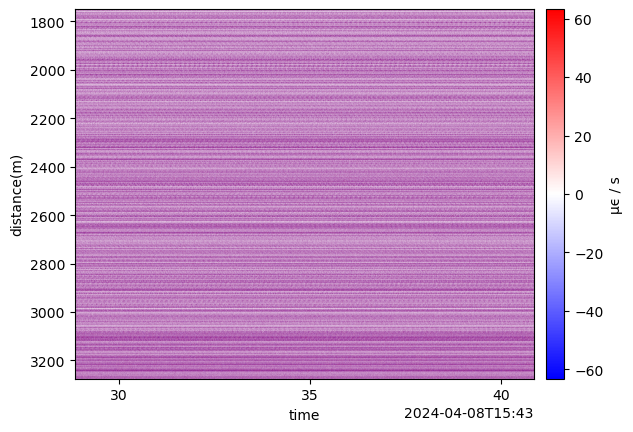

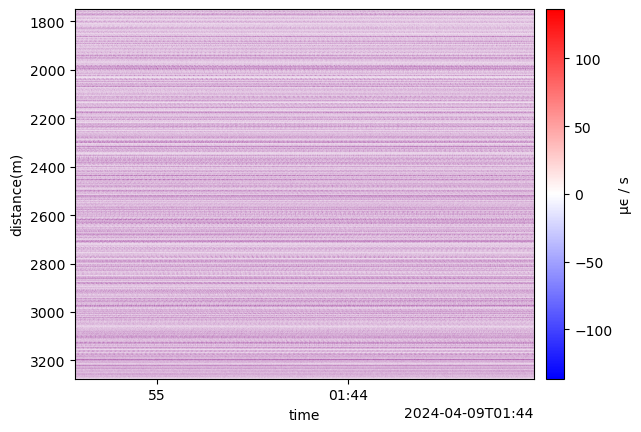

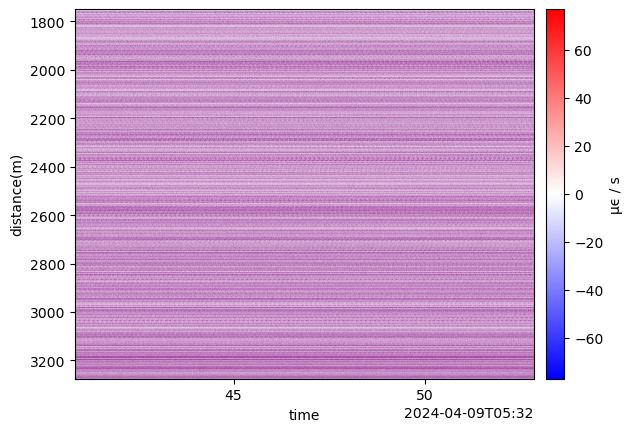

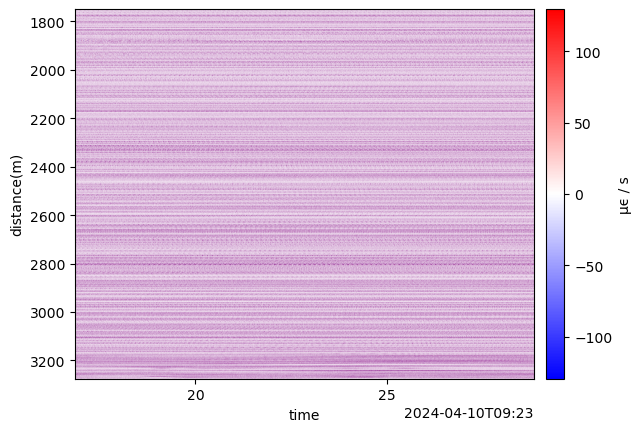

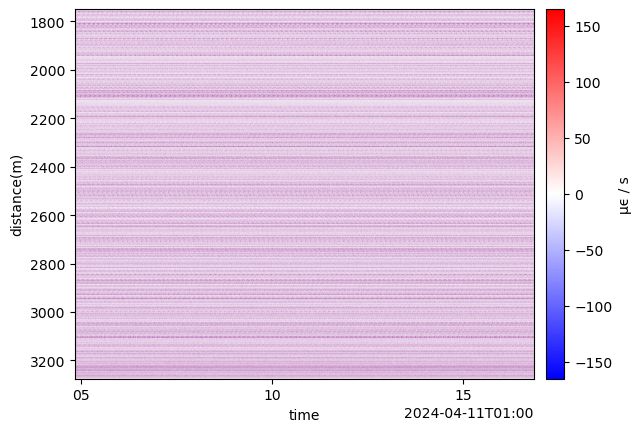

In [13]:
# File paths
csv_file = "/scratch/ddordevic/FORGE/matched_files/matching_catalog_files_2.csv"
h5_folder_path = "/bedrettolab/E1B/DAS/2024_FORGE/DATA_RAW_fromOpenei/April_2024/v1.0.0/"

# Load the CSV file
df = pd.read_csv(csv_file)

# Pick 5 random rows
# random_rows = df.sample(n=5)
random_rows = df.iloc[[0,19,27,46,54]]

# Visualize each HDF5 file
for index, row in random_rows.iterrows():
    h5_filename = row['Matched File']
    h5_filepath = h5_folder_path + h5_filename
    
    try:
        # Load the HDF5 file using dascore
        patch = dc.spool(h5_filepath)[0].transpose()
        
        # Plot the data
        patch.viz.waterfall(show=True, scale=0.05);

    except Exception as e:
        print(f"Error loading {h5_filename}: {e}")

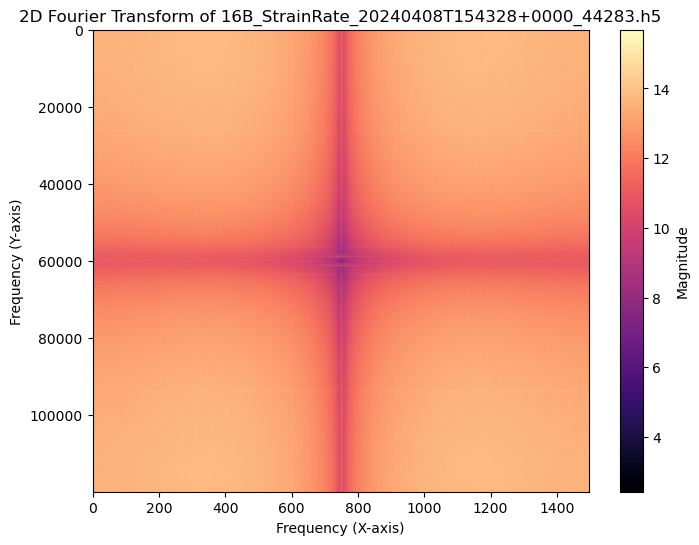

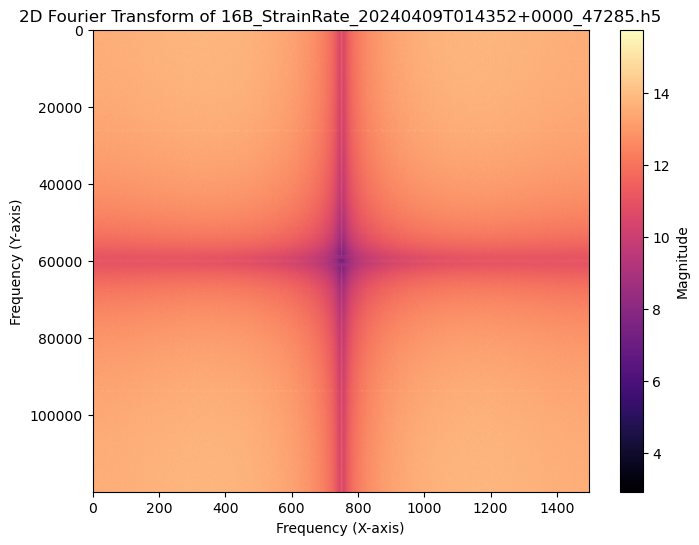

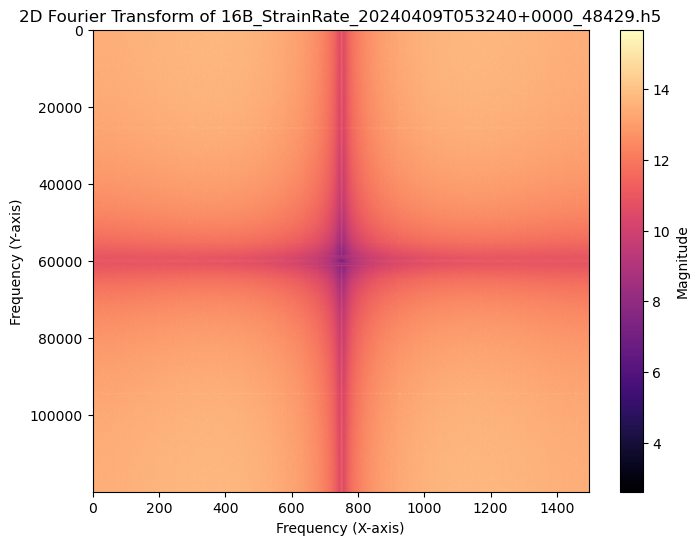

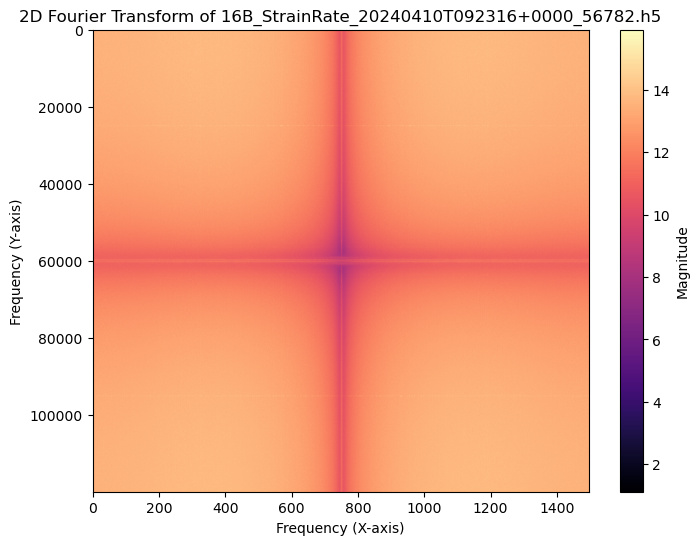

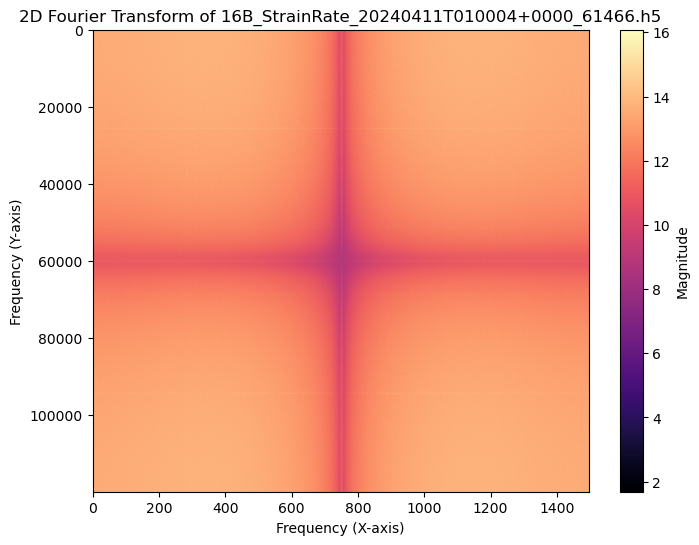

In [14]:
save_folder_path = "/scratch/ddordevic/FORGE/fft_images/"
os.makedirs(save_folder_path, exist_ok=True)

for index, row in random_rows.iterrows():
    h5_filename = row['Matched File']
    h5_filepath = h5_folder_path + h5_filename
    
    try:
        # Load the HDF5 file using dascore
        patch = dc.spool(h5_filepath)[0]

        # Convert the patch to a NumPy array
        data_array = patch.data

        # Compute the 2D Fourier Transform
        fft_result = np.fft.fft2(data_array)
        fft_magnitude = np.abs(fft_result)

        # Shift the zero-frequency component to the center
        fft_magnitude_shifted = np.fft.fftshift(fft_magnitude)

        # Plot the Fourier Transform magnitude spectrum
        plt.figure(figsize=(8, 6))
        plt.imshow(np.log1p(fft_magnitude_shifted), cmap='magma', aspect='auto')
        plt.colorbar(label="Magnitude")
        plt.title(f"2D Fourier Transform of {h5_filename}")
        plt.xlabel("Frequency (X-axis)")
        plt.ylabel("Frequency (Y-axis)")

        image_filename = f"fft_{os.path.splitext(h5_filename)[0]}.png"  # Use the HDF5 filename (without extension)
        save_path = os.path.join(save_folder_path, image_filename)
        plt.savefig(save_path)

    except Exception as e:
        print(f"Error processing {h5_filename}: {e}")